# Project: Wrangling and Analyze Data

In [105]:
#Imports
import  pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import tweepy
from tweepy import OAuthHandler
import json
from bs4 import BeautifulSoup
from datetime import tzinfo
from timeit import default_timer as timer

%matplotlib inline

This report will be used to gather, wrangle and clean data from the twitter user WeRateDogs's tweets about dogs on twitter and their ratings, this report will also include a simple analysis of which dogs are more popular than the rest. Data on this report is gathere from multiple sources, first source is the pre populated csv file twitter_archive_enhanced.csv, the second source is a file generated by a neural network prediciting dogs's race base don their pictures and the final source is from twitter's API to get more info from the twitter user's account directly.

## Data Gathering

In [106]:
#Enahnced twitter archive
we_rate_dogs = pd.read_csv('twitter-archive-enhanced.csv')
we_rate_dogs.shape

(2356, 17)

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [107]:
#Image predictions archive
response = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
#creating the filehandle
with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)
#creating dataframe from image_predictions.tsv
image_predictions = pd.read_csv('image_predictions.tsv', delimiter='\t')
image_predictions.shape

(2075, 12)

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [108]:
#Commenting this section as we already have the desired file and running this piece of code takes time

# #Workaround twitter's api
# import tweepy
# from tweepy import OAuthHandler
# import json
# from timeit import default_timer as timer

# # Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# # These are hidden to comply with Twitter's API terms and conditions
# consumer_key = 'HIDDEN'
# consumer_secret = 'HIDDEN'
# access_token = 'HIDDEN'
# access_secret = 'HIDDEN'

# auth = OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_secret)

# api = tweepy.API(auth, wait_on_rate_limit=True)

# # NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# # df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# # change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# # NOTE TO REVIEWER: this student had mobile verification issues so the following
# # Twitter API code was sent to this student from a Udacity instructor
# # Tweet IDs for which to gather additional data via Twitter's API
# tweet_ids = we_rate_dogs.tweet_id.values
# len(tweet_ids)

# # Query Twitter's API for JSON data for each tweet ID in the Twitter archive
# count = 0
# fails_dict = {}
# start = timer()
# # Save each tweet's returned JSON as a new line in a .txt file
# with open('tweet_json.txt', 'w') as outfile:
#     # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
#     for tweet_id in tweet_ids:
#         count += 1
#         print(str(count) + ": " + str(tweet_id))
#         try:
#             tweet = api.get_status(tweet_id, tweet_mode='extended')
#             print("Success")
#             json.dump(tweet._json, outfile)
#             outfile.write('\n')
#         except tweepy.TweepyException as e:
#             print("Fail")
#             fails_dict[tweet_id] = e
#             pass
# end = timer()
# print(end - start)
# print(fails_dict)


In [109]:
# #Gathering tweet data
# #Will need tweet_id, retweet_count and favorite_count
with open('tweet_json.txt', encoding='utf-8') as file:
    lines = file.readlines()

json_list = []
for i in lines:
    json_list.append(json.loads(i))
tweet_json_full = pd.DataFrame(json_list)
#Getting id, retweet_count & favorite_count
tweet_json = tweet_json_full[['id', 'retweet_count', 'favorite_count']].copy()
tweet_json.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


## Assessing Data

### Quality issues
1. Nan in we_rate_dogs dataframe, replace with "Not available"

2. Clean the urls in we_rate_dogs dataframe

3. Source tab in we_rate_dogs is in HTML structure, will need to convert to text

4. Drop the timezone info from the timestamp

5. 55 rows with name **a**

6. Multiple rows of non dog tweets, these can be filtered by the sequence "we only rate dogs"

7. Convert timestamp do datetime object

8. Row 395 contains a rating of 960 which should be cleaned to 13 only

9. Row 342 has a 75 rating instead of 9.75

11. Rating_denominator should be 10 in all columns, the flair of the ratings could still be preserved by having a higher rating for the dogs in question

12. As per project guidelines, we will drop rows with retweets, these can be filtered by using the str.contains function and setting the pattern for 'RT @' which is present only in and in all retweeted rows

### Tidiness issues
1. Expanded_urls contains two urls instead of one

2. We can have only one dataframe instead of three, tweet_json can be merged into we_rate_dogs for tidiness sake, we can also merge image_predictions with the highest prediction confidence for the dog's race

## Cleaning Data
In this section, we will clean **all** of the issues we documented while assessing. 

**Note:** We wil make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [110]:
# Make copies of original pieces of data
we_rate_dogs_copy = we_rate_dogs.copy()
tweet_json_copy = tweet_json.copy()
image_predictions_copy = image_predictions.copy()

### Quality Issues:

### Quality issues
1. Nan in we_rate_dogs dataframe, replace with "Not available"

2. Clean the urls in we_rate_dogs dataframe

3. Source tab in we_rate_dogs is in HTML structure, will need to convert to text

4. Drop the timezone info from the timestamp

5. 55 rows with name **a**

6. Multiple rows of non dog tweets, these can be filtered by the sequence "we only rate dogs"

7. Convert timestamp do datetime object

8. Row 395 contains a rating of 960 which should be cleaned to 13 only

9. Row 342 has a 75 rating instead of 9.75

11. Rating_denominator should be 10 in all columns, the flair of the ratings could still be preserved by having a higher rating for the dogs in question

12. As per project guidelines, we will drop rows with retweets, these can be filtered by using the str.contains function and setting the pattern for 'RT @' which is present only in and in all retweeted rows

#### Code

In [111]:
#Dropping rows using their indexes
#Getting the rows's indexes using str.contains and .index
retweeted_rows = we_rate_dogs_copy[we_rate_dogs_copy.text.str.contains('RT @')].index
we_rate_dogs_copy = we_rate_dogs_copy.drop(retweeted_rows)
#TEST
we_rate_dogs_copy.shape

(2175, 17)

In [112]:
#Setting timezone info to None in timestamp column using a lambda function to apply
#This will drop the timezone's +0000
#We first convert the column to datetime from str
we_rate_dogs_copy['timestamp'] = pd.to_datetime(we_rate_dogs_copy['timestamp']).apply(lambda x: x.replace(tzinfo=None))
#TEST
we_rate_dogs_copy['timestamp']

0      2017-08-01 16:23:56
1      2017-08-01 00:17:27
2      2017-07-31 00:18:03
3      2017-07-30 15:58:51
4      2017-07-29 16:00:24
               ...        
2351   2015-11-16 00:24:50
2352   2015-11-16 00:04:52
2353   2015-11-15 23:21:54
2354   2015-11-15 23:05:30
2355   2015-11-15 22:32:08
Name: timestamp, Length: 2175, dtype: datetime64[ns]

In [113]:
#Clean 'Source' column to only contain text and remove the HTML tags
#We will use BeautifulSoup library to extract text from HTML
we_rate_dogs_copy['source'] = we_rate_dogs_copy['source'].apply(lambda item: BeautifulSoup(item).get_text())
#TEST
print(we_rate_dogs_copy.source.iloc[744:750])

915    Twitter for iPhone
916    Twitter for iPhone
917    Twitter for iPhone
918    Twitter for iPhone
919    Twitter for iPhone
920    Twitter for iPhone
Name: source, dtype: object


In [114]:
#Setting rating_denominator to 10
we_rate_dogs_copy['rating_denominator'] = 10
#TEST
we_rate_dogs_copy[we_rate_dogs_copy.rating_denominator != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [115]:
#Fixing rows with incorrect data in rating_numerator
def correct_row(df, index, column, value):
    df.at[index, column] = value
#row 393
correct_row(we_rate_dogs_copy, 313, 'rating_numerator', 13)
#row 340
correct_row(we_rate_dogs_copy, 340, 'rating_numerator', 9.75)
#row 45
correct_row(we_rate_dogs_copy, 45, 'rating_numerator', 13.5)
#TEST
row_313 = we_rate_dogs_copy.rating_numerator.iloc[313]
row_340 = we_rate_dogs_copy.rating_numerator.iloc[340]
row_45 = we_rate_dogs_copy.rating_numerator.iloc[45]
print(f'Row 313: {row_313}\n'f'Row 340: {row_340}''\n'f'Row 45: {row_45}\n')

Row 313: 14.0
Row 340: 11.0
Row 45: 13.0



In [116]:
#Dropping rows that are not dog ratings
#Since we haven't yet merged the tables we_rate_dogs_copy and tweet_json_copy, we will be merging them here to avoid repetitive actions
#Merging the two dataframes, changing the column id to tweet_id in tweet_json first to provide a colmun to merge on
tweet_json_copy.rename(columns={'id':'tweet_id'}, inplace=True)
we_rate_dogs_copy = we_rate_dogs_copy.merge(tweet_json_copy)
#Dropping rows
index_to_drop = we_rate_dogs_copy[we_rate_dogs_copy['text'].str.contains('only rate dogs')].index
we_rate_dogs_copy = we_rate_dogs_copy.drop(index_to_drop)
#TEST
we_rate_dogs_copy[we_rate_dogs_copy['text'].str.contains('only rate dogs')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count


In [117]:
#Filling in Nan values with 'Not available'
we_rate_dogs_copy = we_rate_dogs_copy.fillna('Not available')
#TEST
we_rate_dogs_copy.isna().sum()

tweet_id                      0
in_reply_to_status_id         0
in_reply_to_user_id           0
timestamp                     0
source                        0
text                          0
retweeted_status_id           0
retweeted_status_user_id      0
retweeted_status_timestamp    0
expanded_urls                 0
rating_numerator              0
rating_denominator            0
name                          0
doggo                         0
floofer                       0
pupper                        0
puppo                         0
retweet_count                 0
favorite_count                0
dtype: int64

In [118]:
#replace a names with None
we_rate_dogs_copy.name[we_rate_dogs_copy['name'] == 'a'] = we_rate_dogs_copy.name[we_rate_dogs_copy['name'] == 'a'].str.replace('a', 'None')
#TEST
we_rate_dogs_copy[we_rate_dogs_copy['name'] == 'a']

C:\Users\simo-\AppData\Local\Temp\ipykernel_4976\442908781.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  we_rate_dogs_copy.name[we_rate_dogs_copy['name'] == 'a'] = we_rate_dogs_copy.name[we_rate_dogs_copy['name'] == 'a'].str.replace('a', 'None')


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count


### Tidiness issues:

#### Define
1. Expanded_urls contains two urls instead of one

2. We can have only one dataframe instead of three, tweet_json can be merged into we_rate_dogs for tidiness sake, we can also merge image_predictions into this master dataframe

#### Code

In [119]:
#Separating the urls in expanded_urls to two different columns
holder_df = we_rate_dogs_copy.expanded_urls.str.split(",", expand=True)
we_rate_dogs_copy['first_expanded_url'] = holder_df[0]
we_rate_dogs_copy['second_expanded_url'] = holder_df[1]
we_rate_dogs_copy = we_rate_dogs_copy.drop(columns=['expanded_urls'])
#Test
we_rate_dogs_copy.iloc[6]

tweet_id                                                   890006608113172480.0
in_reply_to_status_id                                             Not available
in_reply_to_user_id                                               Not available
timestamp                                                   2017-07-26 00:31:25
source                                                       Twitter for iPhone
text                          This is Koda. He is a South Australian decksha...
retweeted_status_id                                               Not available
retweeted_status_user_id                                          Not available
retweeted_status_timestamp                                        Not available
rating_numerator                                                           13.0
rating_denominator                                                         10.0
name                                                                       Koda
doggo                                   

The tweet_json df was merged in the cleaning step above, we will only merge the image_predictions to the master dataframe now

In [130]:
#merging the dataframes into one
we_rate_dogs_copy = we_rate_dogs_copy.merge(image_predictions_copy)
#TEST
we_rate_dogs_copy.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'rating_numerator', 'rating_denominator',
       'name', 'doggo', 'floofer', 'pupper', 'puppo', 'retweet_count',
       'favorite_count', 'first_expanded_url', 'second_expanded_url',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [121]:
#We will test for Nan values after merging the datasets
we_rate_dogs_copy.isna().sum()

tweet_id                        0
in_reply_to_status_id           0
in_reply_to_user_id             0
timestamp                       0
source                          0
text                            0
retweeted_status_id             0
retweeted_status_user_id        0
retweeted_status_timestamp      0
rating_numerator                0
rating_denominator              0
name                            0
doggo                           0
floofer                         0
pupper                          0
puppo                           0
retweet_count                   0
favorite_count                  0
first_expanded_url              0
second_expanded_url           962
jpg_url                         0
img_num                         0
p1                              0
p1_conf                         0
p1_dog                          0
p2                              0
p2_conf                         0
p2_dog                          0
p3                              0
p3_conf       

Seems that some new Nan values were created by the merging process, filling those with 'Not available' for conformity's sake

In [122]:
we_rate_dogs_copy = we_rate_dogs_copy.fillna('Not available')
#TEST
we_rate_dogs_copy.isna().sum()

tweet_id                      0
in_reply_to_status_id         0
in_reply_to_user_id           0
timestamp                     0
source                        0
text                          0
retweeted_status_id           0
retweeted_status_user_id      0
retweeted_status_timestamp    0
rating_numerator              0
rating_denominator            0
name                          0
doggo                         0
floofer                       0
pupper                        0
puppo                         0
retweet_count                 0
favorite_count                0
first_expanded_url            0
second_expanded_url           0
jpg_url                       0
img_num                       0
p1                            0
p1_conf                       0
p1_dog                        0
p2                            0
p2_conf                       0
p2_dog                        0
p3                            0
p3_conf                       0
p3_dog                        0
dtype: i

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [123]:
we_rate_dogs_copy.shape
we_rate_dogs_copy.to_csv("Twitter_archive_master.csv", index=None)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

### Insights:

We will try to answer the following three questions about this dataset

1. What is the highest rated dog in this dataset
     

2. What is the most common dog name in this dataset 
    
    **sub-question** Number of dogs without name in this dataset
    
    
3. What is the most common device used to upload dogs for rating

In [124]:
#The most common dog name
we_rate_dogs_copy.name.value_counts()

None         377
Oliver         8
Winston        7
Tucker         7
Penny          6
            ... 
Theo           1
Albert         1
Bonaparte      1
Sephie         1
Walter         1
Name: name, Length: 664, dtype: int64

In [125]:
#Highest rated dog
we_rate_dogs_copy['rating_numerator'].max()

1776.0

In [126]:
#Highest rating for a dog under a maximum rating of 20
we_rate_dogs_copy[we_rate_dogs_copy['rating_numerator'] < 20].max()

C:\Users\simo-\AppData\Local\Temp\ipykernel_4976\1586527826.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  we_rate_dogs_copy[we_rate_dogs_copy['rating_numerator'] < 20].max()


tweet_id                                                   891815181378084864.0
timestamp                                                   2017-07-31 00:18:03
source                                                       Twitter for iPhone
text                          😂😂😂 10/10 for the dog and the owner https://t....
retweeted_status_id                                               Not available
retweeted_status_user_id                                          Not available
retweeted_status_timestamp                                        Not available
rating_numerator                                                           14.0
rating_denominator                                                         10.0
name                                                                        the
doggo                                                                     doggo
floofer                                                                 floofer
pupper                                  

In [127]:
we_rate_dogs_copy.source.value_counts()

Twitter for iPhone    1233
Twitter Web Client      18
TweetDeck                8
Name: source, dtype: int64

### Answres:


1. What is the highest rated dog in this dataset: Atticus with a rating of 1776, quite American
     

2. The most common dog name in this dataset: Charlie 
    
    **sub-question** Number of dogs without name in this dataset: 589
    
    
3. Most common device used to upload dogs for rating: iPhone with a count of 1975 uploads

### Visualization

We can visualize a pie chart of the devices being used to upload dogs for rating

Twitter for iPhone    1233
Twitter Web Client      18
TweetDeck                8
Name: source, dtype: int64

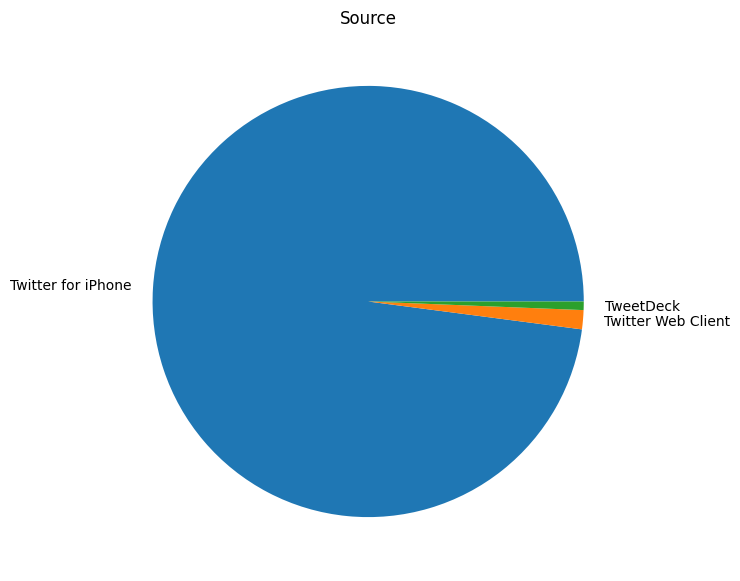

In [128]:
#We will print a pie chart of the column 'source' illustrating the discrepancy between devices used in this dataset
we_rate_dogs_copy.source.value_counts().plot.pie(title='Source', figsize=(7,7), ylabel='')
#value_counts for reference
we_rate_dogs_copy.source.value_counts()